
Processing: evgeny_arbatov.parquet
Found 23 valid routes
Computing DTW for 253 route pairs...
  Processed 100/253 pairs...
  Processed 200/253 pairs...
Average similarity: 0.8710
Min distance: 0.10, Max distance: 27.92


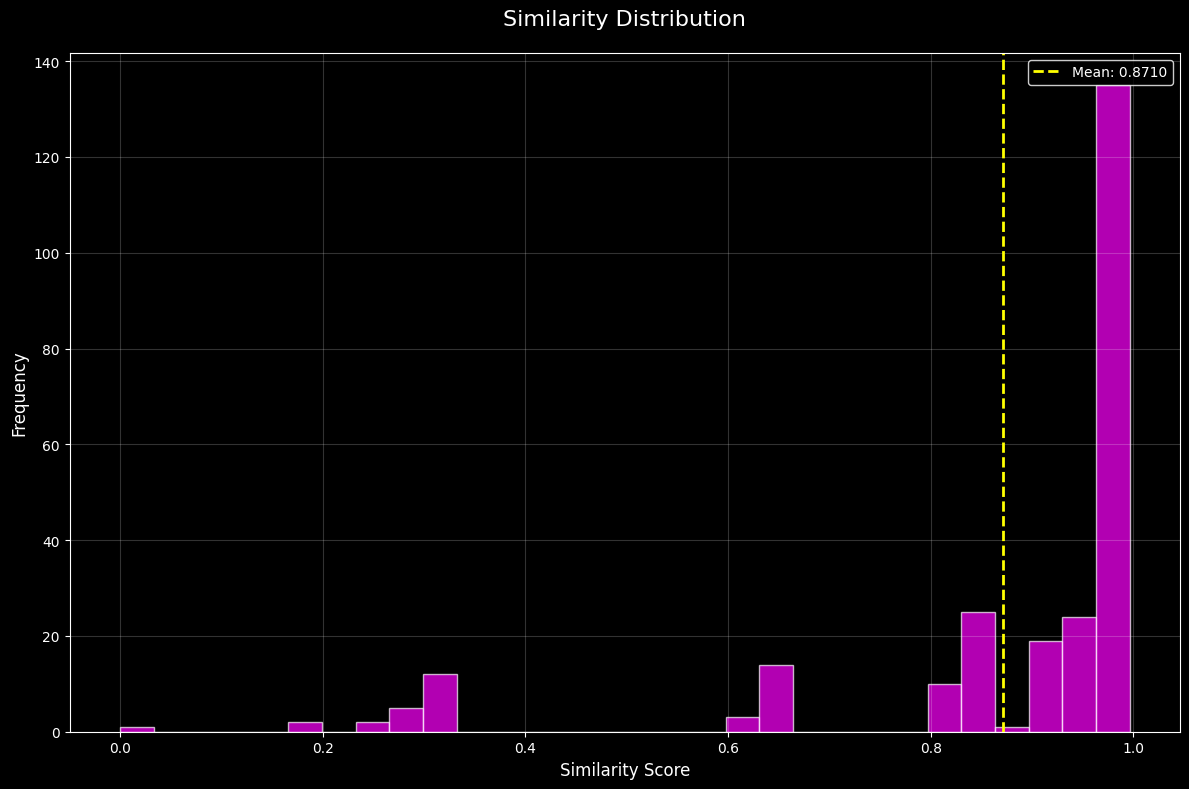

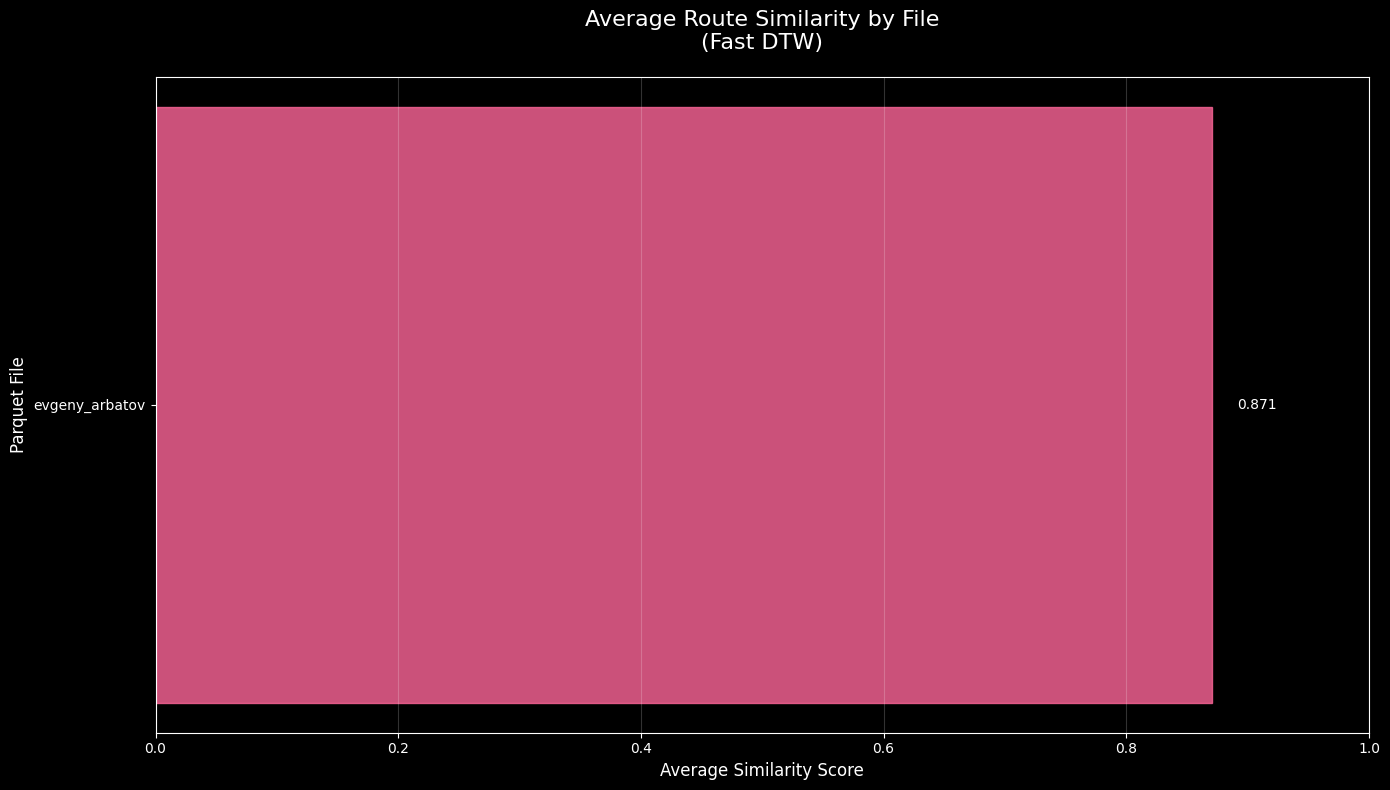


SUMMARY STATISTICS

evgeny_arbatov.parquet:
  Routes: 23
  Comparisons: 253
  Avg Similarity: 0.8710
  Std Dev: 0.2075


In [4]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import os
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

# Get all parquet files in /content
content_dir = '/content'
parquet_files = [f for f in os.listdir(content_dir) if f.endswith('.parquet')]

# Custom colormap - dark to vibrant
colors = ['#4d0099', '#cc00ff', '#ff00ff', '#ff6699', '#ffff00']

def extract_route_coordinates(geometry):
    """Extract coordinates from a geometry as a numpy array."""
    if geometry is None or geometry.is_empty:
        return None
    coords = list(geometry.coords)
    return np.array(coords)

def compute_dtw_distance(route1, route2):
    """Compute Fast DTW distance between two routes using fastdtw library."""
    if route1 is None or route2 is None:
        return None
    try:
        distance, path = fastdtw(route1, route2, dist=euclidean)
        return distance
    except Exception as e:
        print(f"Error computing DTW: {e}")
        return None

def normalize_to_similarity(distance, max_distance):
    """Convert DTW distance to similarity score (0-1 scale)."""
    if distance is None or max_distance == 0:
        return 0
    # Normalize and invert: higher similarity = lower distance
    similarity = 1 - (distance / max_distance)
    return max(0, similarity)

# Store results for all files
results = []

# Process each parquet file separately
for parquet_file in parquet_files:
    print(f"\nProcessing: {parquet_file}")
    file_path = os.path.join(content_dir, parquet_file)

    # Read the parquet file (GeoDataFrame)
    gdf = gpd.read_parquet(file_path)

    # Extract all valid routes
    routes = []
    for idx, geom in enumerate(gdf.geometry):
        coords = extract_route_coordinates(geom)
        if coords is not None and len(coords) > 1:
            routes.append((idx, coords))

    print(f"Found {len(routes)} valid routes")

    if len(routes) < 2:
        print(f"Skipping {parquet_file} - need at least 2 routes")
        continue

    # Compute DTW distances for all pairs
    dtw_distances = []
    total_pairs = (len(routes) * (len(routes) - 1)) // 2
    print(f"Computing DTW for {total_pairs} route pairs...")

    pair_count = 0
    for i, (idx1, route1) in enumerate(routes):
        for idx2, route2 in routes[i+1:]:
            distance = compute_dtw_distance(route1, route2)
            if distance is not None:
                dtw_distances.append(distance)
            pair_count += 1
            if pair_count % 100 == 0:
                print(f"  Processed {pair_count}/{total_pairs} pairs...")

    if len(dtw_distances) == 0:
        print(f"No valid DTW distances computed for {parquet_file}")
        continue

    # Convert distances to similarities
    max_dist = max(dtw_distances)
    similarities = [normalize_to_similarity(d, max_dist) for d in dtw_distances]
    avg_similarity = np.mean(similarities)

    print(f"Average similarity: {avg_similarity:.4f}")
    print(f"Min distance: {min(dtw_distances):.2f}, Max distance: {max_dist:.2f}")

    # Store results
    results.append({
        'file': parquet_file,
        'avg_similarity': avg_similarity,
        'num_routes': len(routes),
        'num_comparisons': len(dtw_distances),
        'similarities': similarities
    })

    # Create visualization for this file - similarity distribution only
    fig, ax = plt.subplots(figsize=(12, 8), facecolor='black')

    ax.set_facecolor('black')
    ax.set_title(f'Similarity Distribution',
                  color='white', fontsize=16, pad=20)

    ax.hist(similarities, bins=30, color='#ff00ff', alpha=0.7, edgecolor='white')
    ax.axvline(avg_similarity, color='#ffff00', linestyle='--', linewidth=2,
                label=f'Mean: {avg_similarity:.4f}')
    ax.set_xlabel('Similarity Score', color='white', fontsize=12)
    ax.set_ylabel('Frequency', color='white', fontsize=12)
    ax.tick_params(colors='white')
    ax.spines['bottom'].set_color('white')
    ax.spines['left'].set_color('white')
    ax.spines['top'].set_color('white')
    ax.spines['right'].set_color('white')
    ax.legend(facecolor='black', edgecolor='white', labelcolor='white')
    ax.grid(True, alpha=0.2, color='white')

    plt.tight_layout()
    plt.savefig(f'/content/dtw_analysis_{parquet_file[:-8]}.png',
                dpi=150, facecolor='black', bbox_inches='tight')
    plt.show()
    plt.close()

# Create summary plot comparing all files
if len(results) > 0:
    fig, ax = plt.subplots(figsize=(14, 8), facecolor='black')
    ax.set_facecolor('black')

    # Sort by average similarity
    results_sorted = sorted(results, key=lambda x: x['avg_similarity'], reverse=True)

    file_names = [r['file'].replace('.parquet', '') for r in results_sorted]
    avg_similarities = [r['avg_similarity'] for r in results_sorted]

    # Create bar plot with gradient colors
    bars = ax.barh(file_names, avg_similarities, color=colors[2], alpha=0.8, edgecolor='white')

    # Color bars based on similarity value
    for bar, sim in zip(bars, avg_similarities):
        color_idx = int(sim * (len(colors) - 1))
        bar.set_color(colors[color_idx])

    ax.set_xlabel('Average Similarity Score', color='white', fontsize=12)
    ax.set_ylabel('Parquet File', color='white', fontsize=12)
    ax.set_title('Average Route Similarity by File\n(Fast DTW)',
                 color='white', fontsize=16, pad=20)
    ax.set_xlim(0, 1)

    # Add value labels on bars
    for i, (bar, sim) in enumerate(zip(bars, avg_similarities)):
        ax.text(sim + 0.02, i, f'{sim:.3f}', va='center', color='white', fontsize=10)

    ax.tick_params(colors='white')
    ax.spines['bottom'].set_color('white')
    ax.spines['left'].set_color('white')
    ax.spines['top'].set_color('white')
    ax.spines['right'].set_color('white')
    ax.grid(True, alpha=0.2, axis='x', color='white')

    plt.tight_layout()
    plt.savefig('/content/dtw_summary_all_files.png',
                dpi=150, facecolor='black', bbox_inches='tight')
    plt.show()
    plt.close()

    # Print summary statistics
    print("\n" + "="*60)
    print("SUMMARY STATISTICS")
    print("="*60)
    for r in results_sorted:
        print(f"\n{r['file']}:")
        print(f"  Routes: {r['num_routes']}")
        print(f"  Comparisons: {r['num_comparisons']}")
        print(f"  Avg Similarity: {r['avg_similarity']:.4f}")
        print(f"  Std Dev: {np.std(r['similarities']):.4f}")
else:
    print("\nNo valid results to plot.")

In [2]:
!pip install fastdtw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp312-cp312-linux_x86_64.whl size=567861 sha256=b0ce94da704a74ec6b0ec6d95e38fb5effdc84100b11ff09b12e594c7472f8de
  Stored in directory: /root/.cache/pip/wheels/ab/d0/26/b82cb0f49ae73e5e6bba4e8462fff2c9851d7bd2ec64f8891e
Successfully built fastdtw
